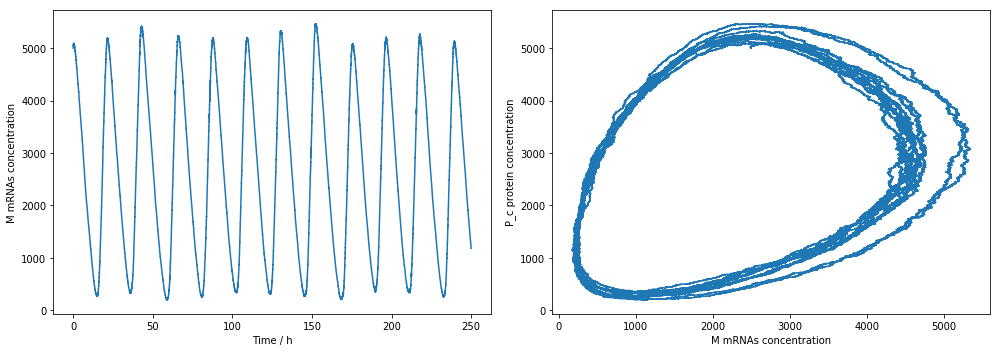

In [10]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import random

random.seed()

# Decides which reaction to use
def sample_reaction(propensity_distribution):
    sample = random.uniform(0,1)
    i = 0
    prob_sum = 0.0
    while prob_sum < sample:
        prob_sum += propensity_distribution[i]
        i += 1
    return i -1
          
def gillespie_draw(parameters, propensity_function, population):
    # Draw a reaction and the time it took to do the reaction
    propensities = propensity_function(parameters, population)
    
    propensity_sum = np.sum(propensities)
    
    # Calculatie the time interval between reactions
    time_interval = - (1 / propensity_sum) * np.log(random.uniform(0,1)) 
    
    propensity_distribution = propensities / propensity_sum # normalise propensities 
    
    
    # Decide which reaction happens by randomly sampling the discrete (normalised) propensity distribution
    reaction = sample_reaction(propensity_distribution)
    
    return reaction, time_interval
  
def gillespie_algorithm(parameters, propensity_function, transitions, population, t_stop):
    '''
    
    '''
    time_points = []
    population_over_time = []
    t = 0
    while t < t_stop:
        # 
        time_points.append(t)
        population_over_time.append(population)
        
        reaction_index, time_interval = gillespie_draw(parameters, propensity_function, population)
        op = transitions[reaction_index]
        
        t += time_interval
        population = np.add(population, op) # Check if np.add can be replaced by + operator   
    return np.array(time_points), np.array(population_over_time)


'''
  Reactions : propensities
  1. M --> M + 1 : W_1
  2. M --> M - 1 : W_2
  3. P_c --> P_c + 1 : W_3
  4. P_c --> P_c - 1 : W_4
  5. P_c --> P_N : W_5
  6. P_N --> P_c : W_6
  
  Initialise system in state with some of all of these proteins
'''
  
clock_transitions = np.array([[1, 0, 0],
                              [-1, 0, 0],
                              [0, 1, 0],
                              [0, -1, 0],
                              [0, -1, 1],
                              [0, 1, -1]], dtype = np.int)
v_s = 1.6
K_1 = 1
n = 4
v_m = 0.5
K_m = 0.5
k_s = 0.5
v_d = 1.4
K_d = 0.13
k_1 = 0.5
k_2 = 0.6
Omega = 1000 # Size of system parameter

clock_parameters = [v_s, K_1, n, v_m, K_m, k_s, v_d, K_d, k_1, k_2, Omega]

population = np.array([5000, 2500, 1000]) # Initialise the system
time_points = np.array([])
simulation_time = 250

# Propensities needs to be a function as the number of molcules affects the liklihood of a reaction
def clock_ttfl(parameters, pop):
    v_s, K_1, n, v_m, K_m, k_s, v_d, K_d, k_1, k_2, Omega = parameters
    M, P_c, P_N = pop
    return np.array([v_s * Omega * (pow(K_1 * Omega, n) / (pow(K_1 * Omega, n) + pow(P_N, n))), 
                     v_m * Omega * (M / (K_m * Omega + M)), 
                     k_s * M,
                     v_d * Omega * (P_c / (K_d * Omega + P_c)),
                     k_1 * P_c,
                     k_2 * P_N])

'''
# Perform stochatsic simulations
simulations = 1
data = []
for i in range(simulations):
    print("Simulation %s" %i)
    random.seed()
    time_points, population = gillespie_algorithm(clock_parameters, clock_ttfl, clock_transitions, population, simulation_time)
    data.append([time_points, population])
    # Re-initialise the system
    population = np.array([5000, 2500, 1000]) # Initialise the system
    time_points = np.array([])

data = np.array(data)
'''

time_points, population = gillespie_algorithm(clock_parameters, clock_ttfl, clock_transitions, population, simulation_time)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot(time_points, population[:,0], '-')

ax[1].plot(population[:,1], population[:,0], '-')

'''
# Plot mRNA trajectories
for i in range(simulations):
    ax[0].plot(data[i,0], ((data[i])[1])[:,0], '-')
    

# Plot P_c trajectories
for i in range(simulations):
    ax[1].plot(data[i,0], (data[i,1])[:,1], 'k-')
    
# Plot P_N trajectories
for i in range(simulations):
    ax[2].plot(data[i,0], (data[i,1])[:,2], 'r-')

# Plot P_c vs M
for i in range(simulations):
    ax[3].plot((data[i,1])[:,1], (data[i,1])[:,0], 'r-')
'''


# Label axes
ax[0].set_xlabel('Time / h')
ax[1].set_xlabel('M mRNAs concentration')
ax[0].set_ylabel('M mRNAs concentration')
ax[1].set_ylabel('P_c protein concentration')
plt.tight_layout()
plt.show()